In [1]:
import json
import vk_api
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [3]:
with open('group.json') as f:
    group = json.load(f)

In [4]:
vk_session = vk_api.VkApi('+79154022284', 'ozopop3618')
vk_session.auth()

vk = vk_session.get_api()

In [5]:
class Person:
    def __init__(self, id, name, vk_id):
        self.id = id
        self.name = name
        self.vk_id = int(vk_id)
        self.friends_vk_id_list = list()
        
    def set_is_accessible(self, is_accessible):
        self.is_accessible = is_accessible

In [6]:
persons = list()
# чтобы в дальнейшем не дублировать
vk_ids = list()

for member in group:
    person = Person(id=len(persons), name=member['name'], vk_id=member['vk_id'])
    persons.append(person)
    vk_ids.append(int(member['vk_id']))

In [7]:
def get_friends():
    new_persons = list()
    
#     добавление друзей в список
    for person in persons:
        if len(person.friends_vk_id_list) == 0:
            try:
                friends = vk.friends.get(user_id=person.vk_id, fields='nickname')['items']
                person.set_is_accessible(True)
            except Exception:
                person.set_is_accessible(False)
                print(f"{person.name}: аккаунт закрыт!")
                continue
                
            for friend in friends:
                if friend.get('deactivated'):
                    continue
                    
                person.friends_vk_id_list.append(friend['id'])
                
                if friend['id'] in vk_ids:
                    continue
                    
                vk_ids.append(friend['id'])
                len_summ = len(persons) + len(new_persons)     
                new_person = Person(id=len_summ,
                                    name=f"{friend['first_name']} {friend['last_name']}",
                                    vk_id=friend['id'])
                new_person.set_is_accessible(friend['can_access_closed'])
                new_persons.append(new_person)

    persons.extend(new_persons)
    
#     добавление оставшимся их списка друзей
    for person in persons:
        if len(person.friends_vk_id_list) == 0 and person.is_accessible:
            try:
                friends = vk.friends.get(user_id=person.vk_id, fields='nickname')['items']
            except Exception as err:
                print(err)
                print(person.__dict__)
                continue
                
            for friend in friends:
                if friend.get('deactivated'):
                    continue

                person.friends_vk_id_list.append(friend['id'])

In [8]:
get_friends()

Иванов Андрей: аккаунт закрыт!


In [9]:
n = len(persons)
R = np.zeros((n, n), dtype=int)

for i, first_person in enumerate(persons):
    for j, second_person in enumerate(persons):
        if first_person != second_person and second_person.vk_id in first_person.friends_vk_id_list:
            R[i][j] = 1
            R[j][i] = 1

In [12]:
def draw(G, pos, measures, measure_name):
    print(measure_name)
    
    plt.figure(figsize=(16, 10))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.cool, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges = nx.draw_networkx_edges(G, pos)


    max_value = max(measures.values())
    indices = [i for i, v in measures.items() if v == max_value]

    for index in indices:
        person = persons[index]
        print(person.id, person.name, person.vk_id)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.savefig(f"{measure_name}.pdf")
    plt.show()

Closeness_centrality
5 Морозова Марина 66857533


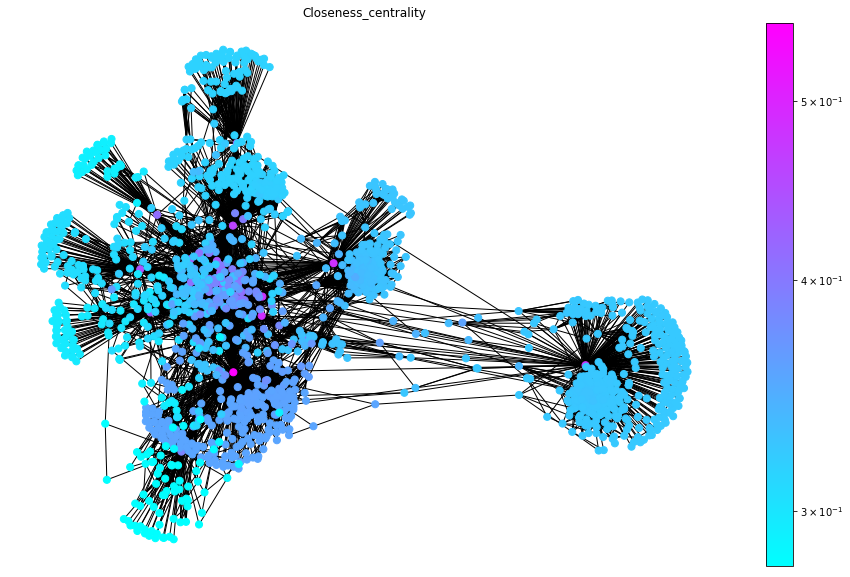

Betweenness_centrality
3 Кибакова Кристина 159934525


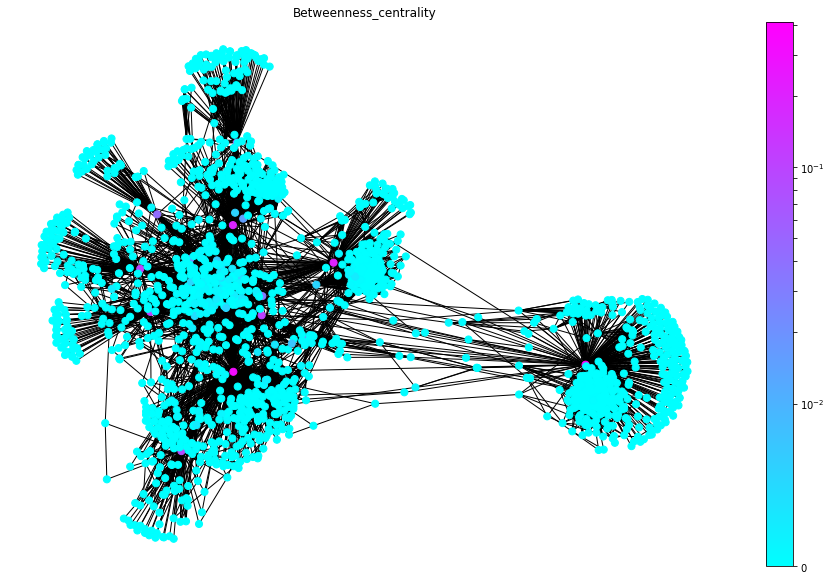

Eigenvector_centrality
2 Лобанов Александр 23208057


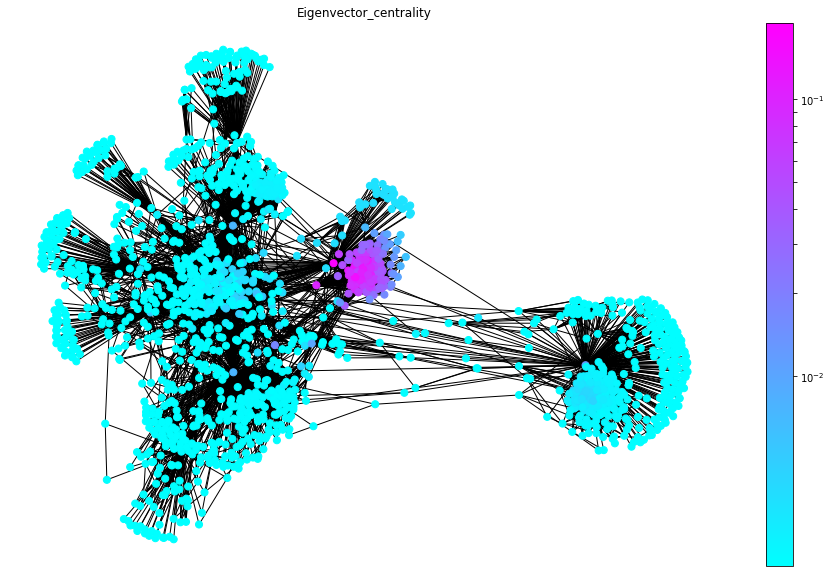

CPU times: user 2min 35s, sys: 3.62 s, total: 2min 38s
Wall time: 2min 34s


In [13]:
%%time
    
rows, cols = np.where(R == 1)
edges = zip(list(rows), list(cols))
G = nx.Graph()
G.add_nodes_from(node for node in range(len(persons)))
G.add_edges_from(edges)
pos = nx.spring_layout(G)

draw(G, pos, nx.closeness_centrality(G), 'Closeness_centrality')
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness_centrality')
draw(G, pos, nx.eigenvector_centrality(G, max_iter=500), 'Eigenvector_centrality')